In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [12]:
X_train = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

In [13]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# size of the layers
l1 = 1024
l2 = 128


In [15]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, 10)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [16]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [18]:
#initialize lists

EPOCHS  = 50

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])
percent_inj_list = []

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias

    if epoch % 5 == 0:
        print("check inj")
        # check injectivity 
        percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
        percent_inj_list.append(percent_inj)
        print("percent_inj: ", percent_inj)

    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
   
accuracy_list

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss 2.301530361175537, Accuracy 0.38280001282691956
check inj


  2%|▏         | 1/50 [00:08<06:51,  8.39s/it]

percent_inj:  0.0


 10%|█         | 5/50 [00:22<03:06,  4.15s/it]

Epoch 5: Loss 1.6806524991989136, Accuracy 0.7864000201225281
check inj


 12%|█▏        | 6/50 [00:32<04:22,  5.97s/it]

percent_inj:  0.0


 20%|██        | 10/50 [00:52<03:41,  5.54s/it]

Epoch 10: Loss 1.5941206216812134, Accuracy 0.8743000030517578
check inj


 22%|██▏       | 11/50 [01:05<04:57,  7.63s/it]

percent_inj:  0.0


 30%|███       | 15/50 [01:50<04:18,  7.40s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

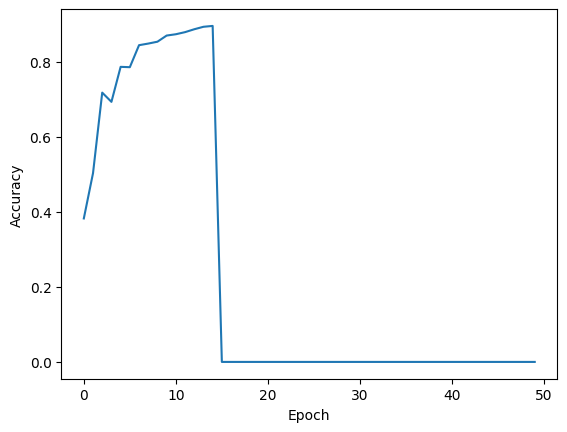

In [19]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# mean over multiple trainings

In [20]:
num_iter = 25
percent_inj2 = []
redundandency = 2

In [ ]:
for i in tqdm.trange(num_iter):

    # size of the layers
    l1 = 784*redundandency
    l2 = 128

    